In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, to_timestamp, date_format, size, split, array_contains, lit
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

Load crash_weather data

In [46]:
#read csv file to dataframe
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("gs://6893_datas/collision_weather.csv", inferSchema=True, header=True)

df.show(2)
print(type(df))

+-------------+--------+--------+---------+---------+--------------------+--------------+-----------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+
|    simp_date| borough|zip code| latitude|longitude|            location|on street name|cross street name|     off street name|number of persons injured|number of persons killed|number of ped

Preprocess
Encode string columns

In [20]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [47]:
df = df.withColumn('hour', split(df['simp_date'], ' ').getItem(1).astype("int"))

numericCols = ["hour", "temperature_2m (°C)", "precipitation (mm)", "rain (mm)", "cloudcover (%)", "cloudcover_low (%)", "cloudcover_mid (%)", \
    "cloudcover_high (%)", "windspeed_10m (km/h)", "winddirection_10m (°)"]
df = df.dropna(subset=numericCols)
#df = df.drop('simp_date')

In [37]:
'''setCategoricalColumns = ["contributing factor vehicle", "vehicle type code"]
categoricalSetList = {}
for categoricalCol in setCategoricalColumns:
    categoricalSet = set()
    for i in range(1, 6):
        name = categoricalCol + ' ' + str(i)
        categoricalSet.update([x[name] for x in df.select(name).distinct().collect()])
    categoricalSetList[categoricalCol] = list(categoricalSet)

for categoricalCol in categoricalSetList.keys():
    print(categoricalCol, len(categoricalSetList[categoricalCol]))'''
df.columns

['simp_date',
 'borough',
 'zip code',
 'latitude',
 'longitude',
 'location',
 'on street name',
 'cross street name',
 'off street name',
 'number of persons injured',
 'number of persons killed',
 'number of pedestrians injured',
 'number of pedestrians killed',
 'number of cyclist injured',
 'number of cyclist killed',
 'number of motorist injured',
 'number of motorist killed',
 'contributing factor vehicle 1',
 'contributing factor vehicle 2',
 'contributing factor vehicle 3',
 'contributing factor vehicle 4',
 'contributing factor vehicle 5',
 'collision_id',
 'vehicle type code 1',
 'vehicle type code 2',
 'vehicle type code 3',
 'vehicle type code 4',
 'vehicle type code 5',
 'date',
 'time',
 'temperature_2m (°C)',
 'precipitation (mm)',
 'rain (mm)',
 'cloudcover (%)',
 'cloudcover_low (%)',
 'cloudcover_mid (%)',
 'cloudcover_high (%)',
 'windspeed_10m (km/h)',
 'winddirection_10m (°)',
 'hour']

In [48]:
df=df[['simp_date',\
 'borough',\
 'zip code',\
 'latitude',\
 'longitude',\
 'location',\
 'on street name',\
 'cross street name',\
 'number of persons injured',\
 'number of persons killed',\
 'number of pedestrians injured',\
 'number of pedestrians killed',\
 'number of cyclist injured',\
 'number of cyclist killed',\
 'number of motorist injured',\
 'number of motorist killed',\
 'contributing factor vehicle 1',\
 'contributing factor vehicle 2',\
 'contributing factor vehicle 3',\
 'contributing factor vehicle 4',\
 'contributing factor vehicle 5',\
 'collision_id',\
 'vehicle type code 1',\
 'vehicle type code 2',\
 'vehicle type code 3',\
 'vehicle type code 4',\
 'vehicle type code 5',\
 'date',\
 'time',\
 'temperature_2m (°C)',\
 'precipitation (mm)',\
 'rain (mm)',\
 'cloudcover (%)',\
 'cloudcover_low (%)',\
 'cloudcover_mid (%)',\
 'cloudcover_high (%)',\
 'windspeed_10m (km/h)',\
 'winddirection_10m (°)',\
 'hour']]
print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [39]:
df.columns

['simp_date',
 'borough',
 'zip code',
 'latitude',
 'longitude',
 'location',
 'on street name',
 'cross street name',
 'number of persons injured',
 'number of persons killed',
 'number of pedestrians injured',
 'number of pedestrians killed',
 'number of cyclist injured',
 'number of cyclist killed',
 'number of motorist injured',
 'number of motorist killed',
 'contributing factor vehicle 1',
 'contributing factor vehicle 2',
 'contributing factor vehicle 3',
 'contributing factor vehicle 4',
 'contributing factor vehicle 5',
 'collision_id',
 'vehicle type code 1',
 'vehicle type code 2',
 'vehicle type code 3',
 'vehicle type code 4',
 'vehicle type code 5',
 'date',
 'time',
 'temperature_2m (°C)',
 'precipitation (mm)',
 'rain (mm)',
 'cloudcover (%)',
 'cloudcover_low (%)',
 'cloudcover_mid (%)',
 'cloudcover_high (%)',
 'windspeed_10m (km/h)',
 'winddirection_10m (°)',
 'hour']

In [40]:
df_concat = df.withColumn("contributing factor", concat_ws("  ", col("contributing factor vehicle 1"), col("contributing factor vehicle 2")\
                                               , col("contributing factor vehicle 3"), col("contributing factor vehicle 4")\
                                               , col("contributing factor vehicle 5")))\
    .withColumn("contributing factor", split(col("contributing factor"), "  "))
df_concat = df_concat.drop("contributing factor vehicle 1", "contributing factor vehicle 2", "contributing factor vehicle 3"\
             , "contributing factor vehicle 4", "contributing factor vehicle 5")

df_concat = df_concat.withColumn("vehicle type code", concat_ws("  ", col("vehicle type code 1"), col("vehicle type code 2"), col("vehicle type code 3")\
                                                  , col("vehicle type code 4"), col("vehicle type code 5")))\
    .withColumn("vehicle type code", split(col("vehicle type code"), "  "))
df_concat = df_concat.drop("vehicle type code 1", "vehicle type code 2", "vehicle type code 3", "vehicle type code 4", "vehicle type code 5")

df_concat.select("contributing factor", "vehicle type code").show(3)

+--------------------+-----------------+
| contributing factor|vehicle type code|
+--------------------+-----------------+
|       [Unspecified]|          [Sedan]|
|[Unspecified, Uns...|   [Sedan, Sedan]|
|[Driver Inexperie...|          [Sedan]|
+--------------------+-----------------+
only showing top 3 rows



In [41]:
# explode based on columns vehicle type code and contributing factor
rdd = df_concat.select(["collision_id", "vehicle type code"]).rdd
rdd = rdd.flatMap(lambda x: [(x[0], x1) for x1 in x[1]])
df_epd = rdd.toDF(["collision_id", "vehicle type code"])
df_epd = df_epd.join(df_concat.drop("vehicle type code"), on="collision_id", how='inner')
df_epd.select(["collision_id", "vehicle type code"]).show(6)

+------------+--------------------+
|collision_id|   vehicle type code|
+------------+--------------------+
|     4456314|               Sedan|
|     4486660|               Sedan|
|     4486660|               Sedan|
|     4487074|               Sedan|
|     4486519|               Sedan|
|     4486519|Station Wagon/Spo...|
+------------+--------------------+
only showing top 6 rows



In [42]:
stages = []
categoricalColumns = ["borough","zip code","on street name","cross street name", "contributing factor vehicle 1",\
    "contributing factor vehicle 2","contributing factor vehicle 3", "contributing factor vehicle 4", "contributing factor vehicle 5", \
    "vehicle type code 1", "vehicle type code 2", "vehicle type code 3", "vehicle type code 4", "vehicle type code 5"]
for categoricalCol in categoricalColumns:
    # use StringIndexer to Category Indexing
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index").setHandleInvalid("keep")
    # use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "Vec"])
    stages += [stringIndexer, encoder]

In [43]:
# transform all features into a vector using VectorAssembler
numericCols = ["hour", "temperature_2m (°C)", "precipitation (mm)", "rain (mm)", "cloudcover (%)", "cloudcover_low (%)", "cloudcover_mid (%)", \
    "cloudcover_high (%)", "windspeed_10m (km/h)", "winddirection_10m (°)"]
assemblerInputs = [c + "Vec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [44]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df1 = pipelineModel.transform(df)

df1.show(1)

22/12/16 03:40:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.8 MiB


+-------------+--------+--------+---------+---------+--------------------+--------------+-----------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+----+------------+-------------+-------------+---------------+-------------------+-----------------+----------------------+--------------------+----------------------------------+--------------------------------+--

Correlation

In [11]:
from pyspark.ml.stat import Correlation

In [12]:
cor_list = ["number of persons injured", "number of persons killed"] + numericCols + [c + "Index" for c in categoricalColumns]
df_cor = df1.select(cor_list).dropna()

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_cor.columns, outputCol=vector_col)
df_vector = assembler.transform(df_cor).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]

22/12/04 23:52:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/12/04 23:52:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/12/04 23:53:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/12/04 23:53:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 8.2 MiB


In [13]:
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = cor_list, index=cor_list) 
corr_matrix_df .style.background_gradient(cmap='coolwarm').set_precision(2)

,number of persons injured,number of persons killed,hour,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),boroughIndex,zip codeIndex,on street nameIndex,cross street nameIndex,off street nameIndex,contributing factor vehicle 1Index,contributing factor vehicle 2Index,contributing factor vehicle 3Index,contributing factor vehicle 4Index,contributing factor vehicle 5Index,vehicle type code 1Index,vehicle type code 2Index,vehicle type code 3Index,vehicle type code 4Index,vehicle type code 5Index
number of persons injured,1.00,0.02,0.03,0.05,-0.00,0.00,-0.00,-0.01,-0.00,-0.00,-0.01,-0.00,-0.02,-0.03,-0.12,-0.11,0.10,0.05,0.08,-0.12,-0.08,-0.05,0.00,0.02,-0.12,-0.09,-0.05
number of persons killed,0.02,1.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.02,-0.01,0.01,0.01,0.03,-0.01,-0.02,-0.02,0.00,0.02,-0.01,-0.02,-0.02
hour,0.03,-0.00,1.00,0.14,0.02,0.02,0.07,0.05,0.06,-0.00,0.10,0.01,-0.01,-0.00,-0.02,-0.02,0.01,-0.04,-0.01,0.04,0.03,0.02,-0.01,-0.02,0.04,0.03,0.02
temperature_2m (°C),0.05,0.00,0.14,1.00,0.02,0.05,-0.00,-0.02,-0.09,0.05,-0.20,-0.06,-0.00,-0.01,0.03,0.03,-0.03,-0.02,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,-0.01,-0.00,-0.00
precipitation (mm),-0.00,0.00,0.02,0.02,1.00,0.97,0.30,0.30,0.35,0.22,0.15,-0.15,-0.00,0.00,-0.00,-0.00,0.00,0.01,0.01,0.00,0.00,-0.00,-0.00,0.01,0.00,0.00,-0.00
rain (mm),0.00,0.00,0.02,0.05,0.97,1.00,0.29,0.29,0.32,0.21,0.12,-0.14,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.01,0.00,-0.00,-0.00,-0.00,0.01,0.00,-0.00,-0.00
cloudcover (%),-0.00,-0.00,0.07,-0.00,0.30,0.29,1.00,0.80,0.73,0.52,0.06,-0.32,-0.00,-0.00,-0.01,-0.00,0.00,0.00,0.01,0.01,0.00,0.00,-0.00,0.00,0.01,0.00,0.00
cloudcover_low (%),-0.01,-0.00,0.05,-0.02,0.30,0.29,0.80,1.00,0.40,0.18,0.11,-0.28,-0.00,0.00,-0.00,-0.00,0.00,-0.01,0.01,0.01,0.01,0.00,-0.00,0.00,0.01,0.01,0.00
cloudcover_mid (%),-0.00,-0.00,0.06,-0.09,0.35,0.32,0.73,0.40,1.00,0.37,0.11,-0.23,0.00,0.00,-0.01,-0.01,0.01,0.01,0.01,0.00,0.00,-0.00,-0.00,0.01,0.00,0.00,-0.00
cloudcover_high (%),-0.00,-0.00,-0.00,0.05,0.22,0.21,0.52,0.18,0.37,1.00,-0.08,-0.24,-0.00,-0.00,-0.00,-0.00,0.00,0.01,0.01,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00


<AxesSubplot:>

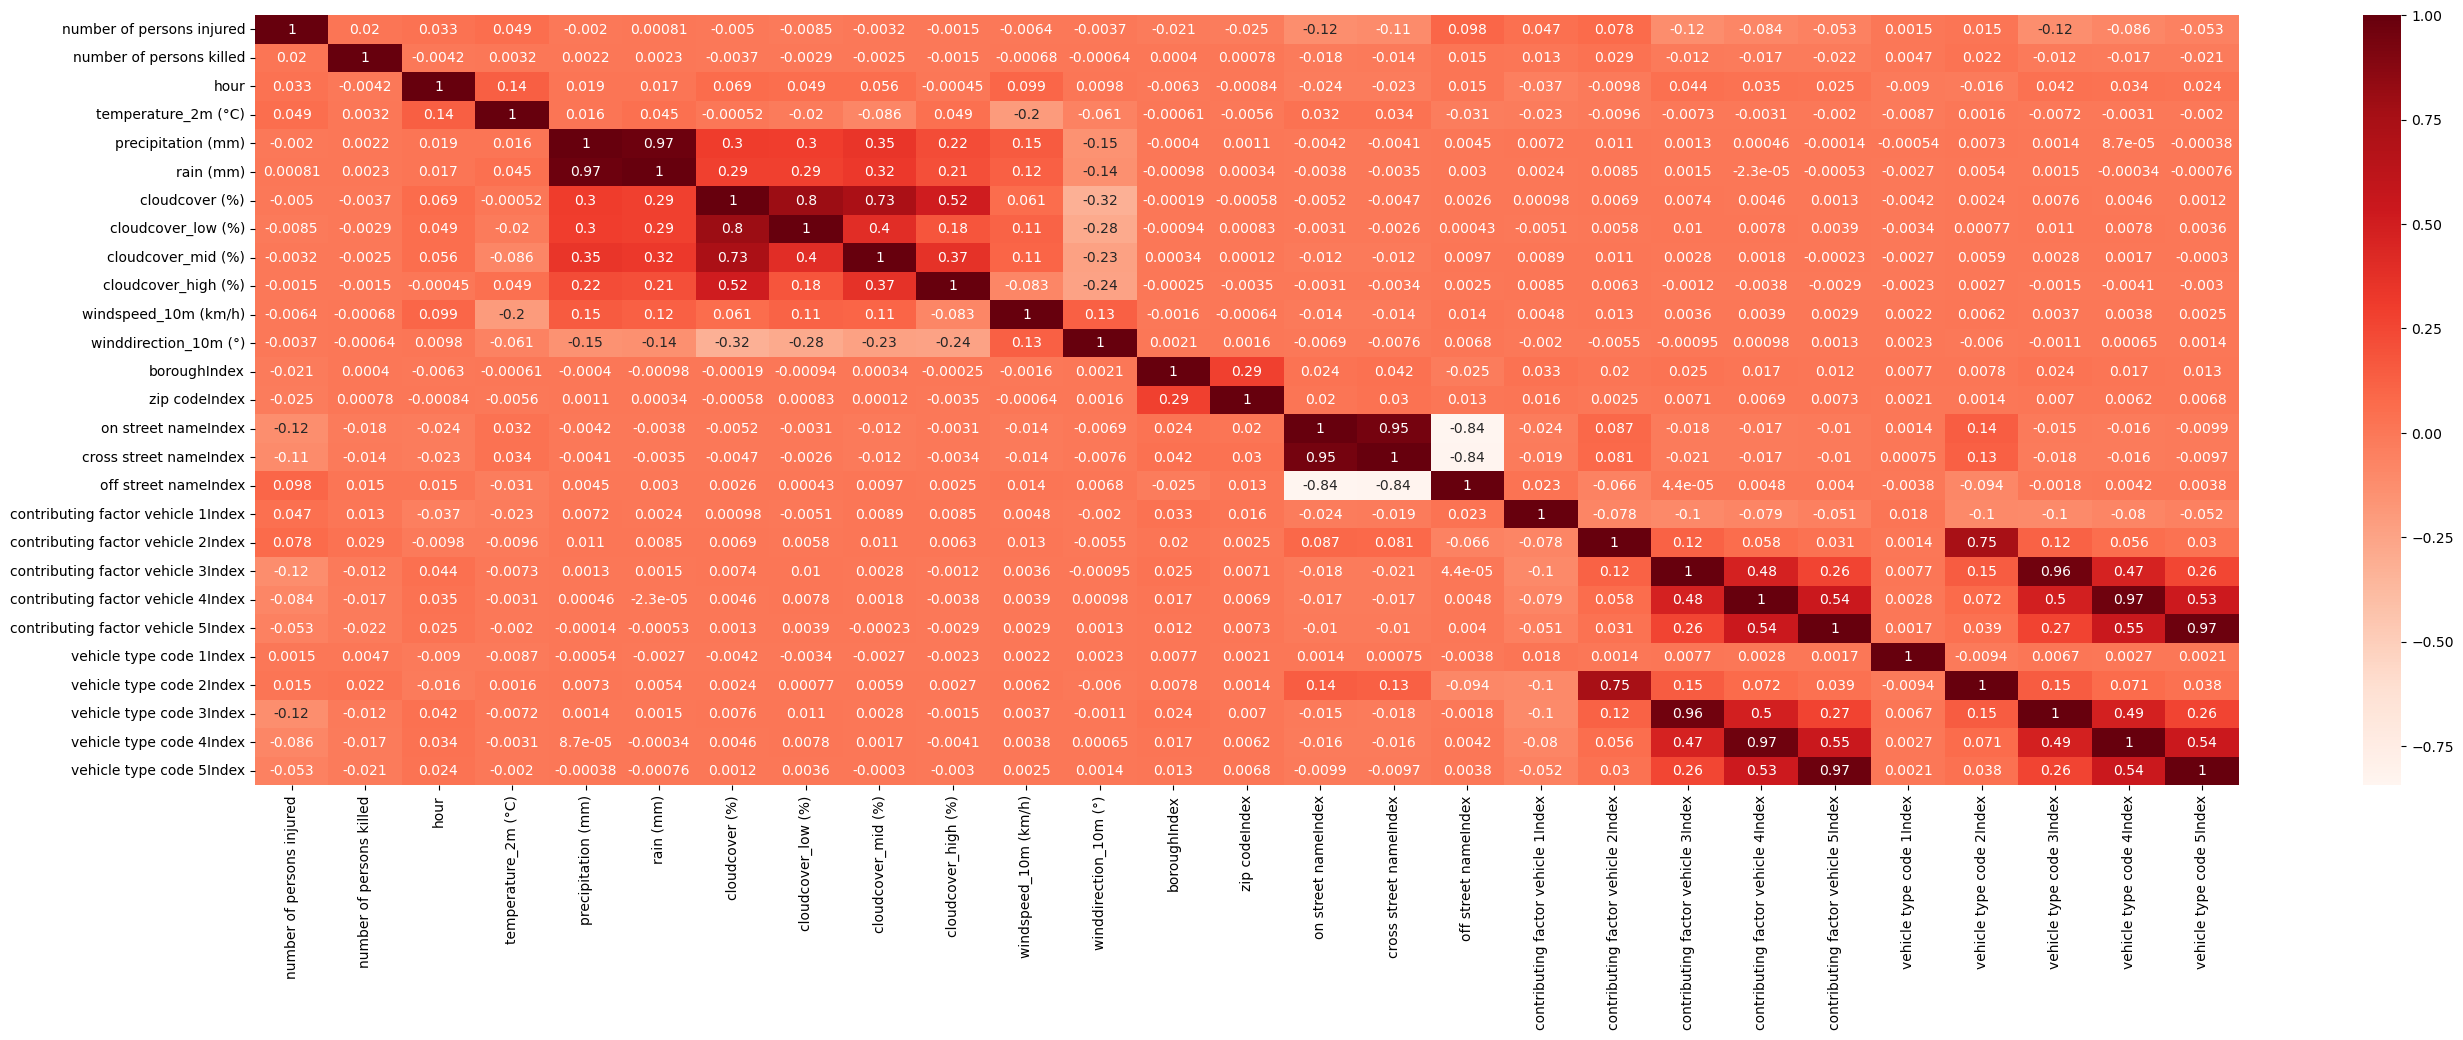

In [14]:
plt.figure(figsize=(32,10))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Reds", annot=True)

Modeling

In [59]:
# df1 = df1.withColumn("label", lit(1))
# df_model = df1.select("label", "features")
# (trainingData, testData) = df_model.take(100000).randomSplit([0.7, 0.3])

In [64]:
import random
def split(full_list,shuffle=False,ratio=0.2):
    n_total = len(full_list)
    offset = int(n_total * ratio)
    if n_total==0 or offset<1:
        return [],full_list
    if shuffle:
        random.shuffle(full_list)
    sublist_1 = full_list[:offset]
    sublist_2 = full_list[offset:]
    return sublist_1,sublist_2
df1 = df1.withColumn("label", lit(1))
df_model = df1.select("label", "features")
(trainingData, testData) = split(df_model.take(100000),shuffle=True,ratio=0.7)

22/12/16 04:18:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1005.9 KiB


In [23]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rfModel = rf.fit(trainingData)

rfPredictions = rfModel.transform(testData)
rfPredictions.show()

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rfAccuracy = evaluator.evaluate(rfPredictions)
print("Test set accuracy of Random Forest = " + str(rfAccuracy))

22/12/05 00:04:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 29.8 MiB
22/12/05 00:05:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 29.8 MiB
22/12/05 00:05:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 29.8 MiB
22/12/05 00:05:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 29.8 MiB
22/12/05 00:06:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/12/05 00:06:12 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 34.4 MiB
22/12/05 00:06:34 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1670180895104_0003_01_000007 on host: cluster-6893project-m.us-east1-c.c.big-data-6893-362413.internal. Exit status: 137. Diagnostics: [2022-12-05 00:06:34.295]Container killed on request. Exit code is 137
[2022-1

KeyboardInterrupt: 

In [62]:
trainingData.show(3)

22/12/16 04:03:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.8 MiB


+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(15108,[0,5,234,6...|
|    1|(15108,[0,5,234,6...|
|    1|(15108,[0,5,234,6...|
+-----+--------------------+
only showing top 3 rows



In [ ]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(gamma='auto').fit(trainingData)

ValueError: setting an array element with a sequence.

In [71]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, to_timestamp, date_format, size, split, array_contains, lit
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("gs://6893_datas/collision_weather_small.csv", inferSchema=True, header=True)

df.show(2)
print(type(df))
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
df = df.withColumn('hour', split(df['simp_date'], ' ').getItem(1).astype("int"))

numericCols = ["hour", "temperature_2m (C)", "precipitation (mm)", "rain (mm)", "cloudcover (%)", "cloudcover_low (%)", "cloudcover_mid (%)", \
    "cloudcover_high (%)", "windspeed_10m (km/h)", "winddirection_10m ()"]
df = df.dropna(subset=numericCols)
#df = df.drop('simp_date')
df=df[['simp_date',\
 'borough',\
 'zip code',\
 'latitude',\
 'longitude',\
 'location',\
 'on street name',\
 'cross street name',\
 'number of persons injured',\
 'number of persons killed',\
 'number of pedestrians injured',\
 'number of pedestrians killed',\
 'number of cyclist injured',\
 'number of cyclist killed',\
 'number of motorist injured',\
 'number of motorist killed',\
 'contributing factor vehicle 1',\
 'contributing factor vehicle 2',\
 'contributing factor vehicle 3',\
 'contributing factor vehicle 4',\
 'contributing factor vehicle 5',\
 'collision_id',\
 'vehicle type code 1',\
 'vehicle type code 2',\
 'vehicle type code 3',\
 'vehicle type code 4',\
 'vehicle type code 5',\
 'date',\
 'time',\
 'temperature_2m (C)',\
 'precipitation (mm)',\
 'rain (mm)',\
 'cloudcover (%)',\
 'cloudcover_low (%)',\
 'cloudcover_mid (%)',\
 'cloudcover_high (%)',\
 'windspeed_10m (km/h)',\
 'winddirection_10m ()',\
 'hour']]
print(type(df))
df_concat = df.withColumn("contributing factor", concat_ws("  ", col("contributing factor vehicle 1"), col("contributing factor vehicle 2")\
                                               , col("contributing factor vehicle 3"), col("contributing factor vehicle 4")\
                                               , col("contributing factor vehicle 5")))\
    .withColumn("contributing factor", split(col("contributing factor"), "  "))
df_concat = df_concat.drop("contributing factor vehicle 1", "contributing factor vehicle 2", "contributing factor vehicle 3"\
             , "contributing factor vehicle 4", "contributing factor vehicle 5")

df_concat = df_concat.withColumn("vehicle type code", concat_ws("  ", col("vehicle type code 1"), col("vehicle type code 2"), col("vehicle type code 3")\
                                                  , col("vehicle type code 4"), col("vehicle type code 5")))\
    .withColumn("vehicle type code", split(col("vehicle type code"), "  "))
df_concat = df_concat.drop("vehicle type code 1", "vehicle type code 2", "vehicle type code 3", "vehicle type code 4", "vehicle type code 5")

df_concat.select("contributing factor", "vehicle type code").show(3)
rdd = df_concat.select(["collision_id", "vehicle type code"]).rdd
rdd = rdd.flatMap(lambda x: [(x[0], x1) for x1 in x[1]])
df_epd = rdd.toDF(["collision_id", "vehicle type code"])
df_epd = df_epd.join(df_concat.drop("vehicle type code"), on="collision_id", how='inner')
df_epd.select(["collision_id", "vehicle type code"]).show(6)
stages = []
categoricalColumns = ["borough","zip code","on street name","cross street name", "contributing factor vehicle 1",\
    "contributing factor vehicle 2","contributing factor vehicle 3", "contributing factor vehicle 4", "contributing factor vehicle 5", \
    "vehicle type code 1", "vehicle type code 2", "vehicle type code 3", "vehicle type code 4", "vehicle type code 5"]
for categoricalCol in categoricalColumns:
    # use StringIndexer to Category Indexing
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index").setHandleInvalid("keep")
    # use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "Vec"])
    stages += [stringIndexer, encoder]
# transform all features into a vector using VectorAssembler
numericCols = ["hour", "temperature_2m (C)", "precipitation (mm)", "rain (mm)", "cloudcover (%)", "cloudcover_low (%)", "cloudcover_mid (%)", \
    "cloudcover_high (%)", "windspeed_10m (km/h)", "winddirection_10m ()"]
assemblerInputs = [c + "Vec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df1 = pipelineModel.transform(df)
df1 = df1.withColumn("label", lit(1))
df_model = df1.select("label","features")
(trainingData, testData) = df_model.randomSplit([0.7, 0.3],100)

+-------------+--------+--------+---------+---------+--------------------+--------------+-----------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------+------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+--------------------+
|    simp_date| borough|zip code| latitude|longitude|            location|on street name|cross street name|     off street name|number of persons injured|number of persons killed|number of pedes

In [74]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df_model)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df_model)


# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             1|    1|(1284,[0,5,185,64...|
|             1|    1|(1284,[0,5,209,70...|
|             1|    1|(1284,[0,5,262,67...|
|             1|    1|(1284,[0,5,413,69...|
|             1|    1|(1284,[0,5,422,96...|
+--------------+-----+--------------------+
only showing top 5 rows



Test set accuracy = 1.0


In [75]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
dataset6=df_model
splits = dataset6.randomSplit([0.7, 0.3], 1234)
train = splits[0]
test = splits[1]

# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [4, 5, 4, 3]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

22/12/16 08:28:21 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/16 08:28:21 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/12/16 08:28:22 ERROR breeze.optimize.LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
22/12/16 08:28:23 ERROR breeze.optimize.LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


Test set accuracy = 0.0


In [76]:
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
# Load and parse the data file.
dataset5 = df_model
data_assembled = dataset5.select(col("label"), col("features"))
datardd=data_assembled.rdd
d = datardd.map(lambda line: LabeledPoint(line[0],[line[1]]))
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = d.randomSplit([0.7, 0.3],100)

# Train a GradientBoostedTrees model.
#  Notes: (a) Empty categoricalFeaturesInfo indicates all features are continuous.
#         (b) Use more iterations in practice.
model = GradientBoostedTrees.trainClassifier(trainingData,categoricalFeaturesInfo={}, numIterations=3)

# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(testData.count())
print('Test accuracy = ' + str(1-testErr))

22/12/16 08:30:06 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 290.0 (TID 284) (coms6893-w-1.us-central1-b.c.big-data-6893-363021.internal executor 1): java.lang.IllegalArgumentException: requirement failed: Sparse vectors require that the dimension of the indices match the dimension of the values. You provided 0 indices and  8 values.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.SparseVector.<init>(Vectors.scala:611)
	at org.apache.spark.ml.linalg.VectorUDT.deserialize(VectorUDT.scala:64)
	at org.apache.spark.ml.linalg.VectorUDT.deserialize(VectorUDT.scala:28)
	at org.apache.spark.sql.catalyst.CatalystTypeConverters$UDTConverter.toScala(CatalystTypeConverters.scala:150)
	at org.apache.spark.sql.catalyst.CatalystTypeConverters$UDTConverter.toScalaImpl(CatalystTypeConverters.scala:154)
	at org.apache.spark.sql.catalyst.CatalystTypeConverters$CatalystTypeConverter.toScala(CatalystTypeConverters.scala:115)
	at org.apache.spark.sql.ca

Test accuracy = 1.0


In [85]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, to_timestamp, date_format, size, split, array_contains, lit
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("gs://6893_datas/collision_weather.csv", inferSchema=True, header=True)

df.show(2)
print(type(df))
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
df = df.withColumn('hour', split(df['simp_date'], ' ').getItem(1).astype("int"))

numericCols = ["hour", "temperature_2m (°C)", "precipitation (mm)", "rain (mm)", "cloudcover (%)", "cloudcover_low (%)", "cloudcover_mid (%)", \
    "cloudcover_high (%)", "windspeed_10m (km/h)", "winddirection_10m (°)"]
df = df.dropna(subset=numericCols)
#df = df.drop('simp_date')
df=df[[
 'zip code',\
 'latitude',\
 'longitude',\
 'number of persons injured',\
 'number of persons killed',\
 'number of pedestrians injured',\
 'number of pedestrians killed',\
 'number of cyclist injured',\
 'number of cyclist killed',\
 'number of motorist injured',\
 'number of motorist killed',\
 'temperature_2m (°C)',\
 'precipitation (mm)',\
 'rain (mm)',\
 'cloudcover (%)',\
 'cloudcover_low (%)',\
 'cloudcover_mid (%)',\
 'cloudcover_high (%)',\
 'windspeed_10m (km/h)',\
 'winddirection_10m (°)',\
 'hour']]
import random
def split(full_list,shuffle=False,ratio=0.2):
    n_total = len(full_list)
    offset = int(n_total * ratio)
    if n_total==0 or offset<1:
        return [],full_list
    if shuffle:
        random.shuffle(full_list)
    sublist_1 = full_list[:offset]
    sublist_2 = full_list[offset:]
    return sublist_1,sublist_2
(trainingData, testData) = split(df.take(100000),shuffle=True,ratio=0.7)

+-------------+--------+--------+---------+---------+--------------------+--------------+-----------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+
|    simp_date| borough|zip code| latitude|longitude|            location|on street name|cross street name|     off street name|number of persons injured|number of persons killed|number of ped

In [ ]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(gamma='auto').fit(trainingData)

In [87]:
a=clf.predict(testData)

In [88]:
sum(a)

-27862

In [89]:
len(a)

30000

In [92]:
correctness=(len(a)-sum(a))*0.5/len(a)

In [93]:
print(correctness)

0.9643666666666667


In [97]:
w=np.empty((80,80),dtype=np.float32)
for i in range(80):
    for j in range(80):
        w[i][j]=a[i*80+j]
print(w)

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ... -1. -1. -1.]
 [-1. -1.  1. ... -1.  1. -1.]]


<AxesSubplot:>

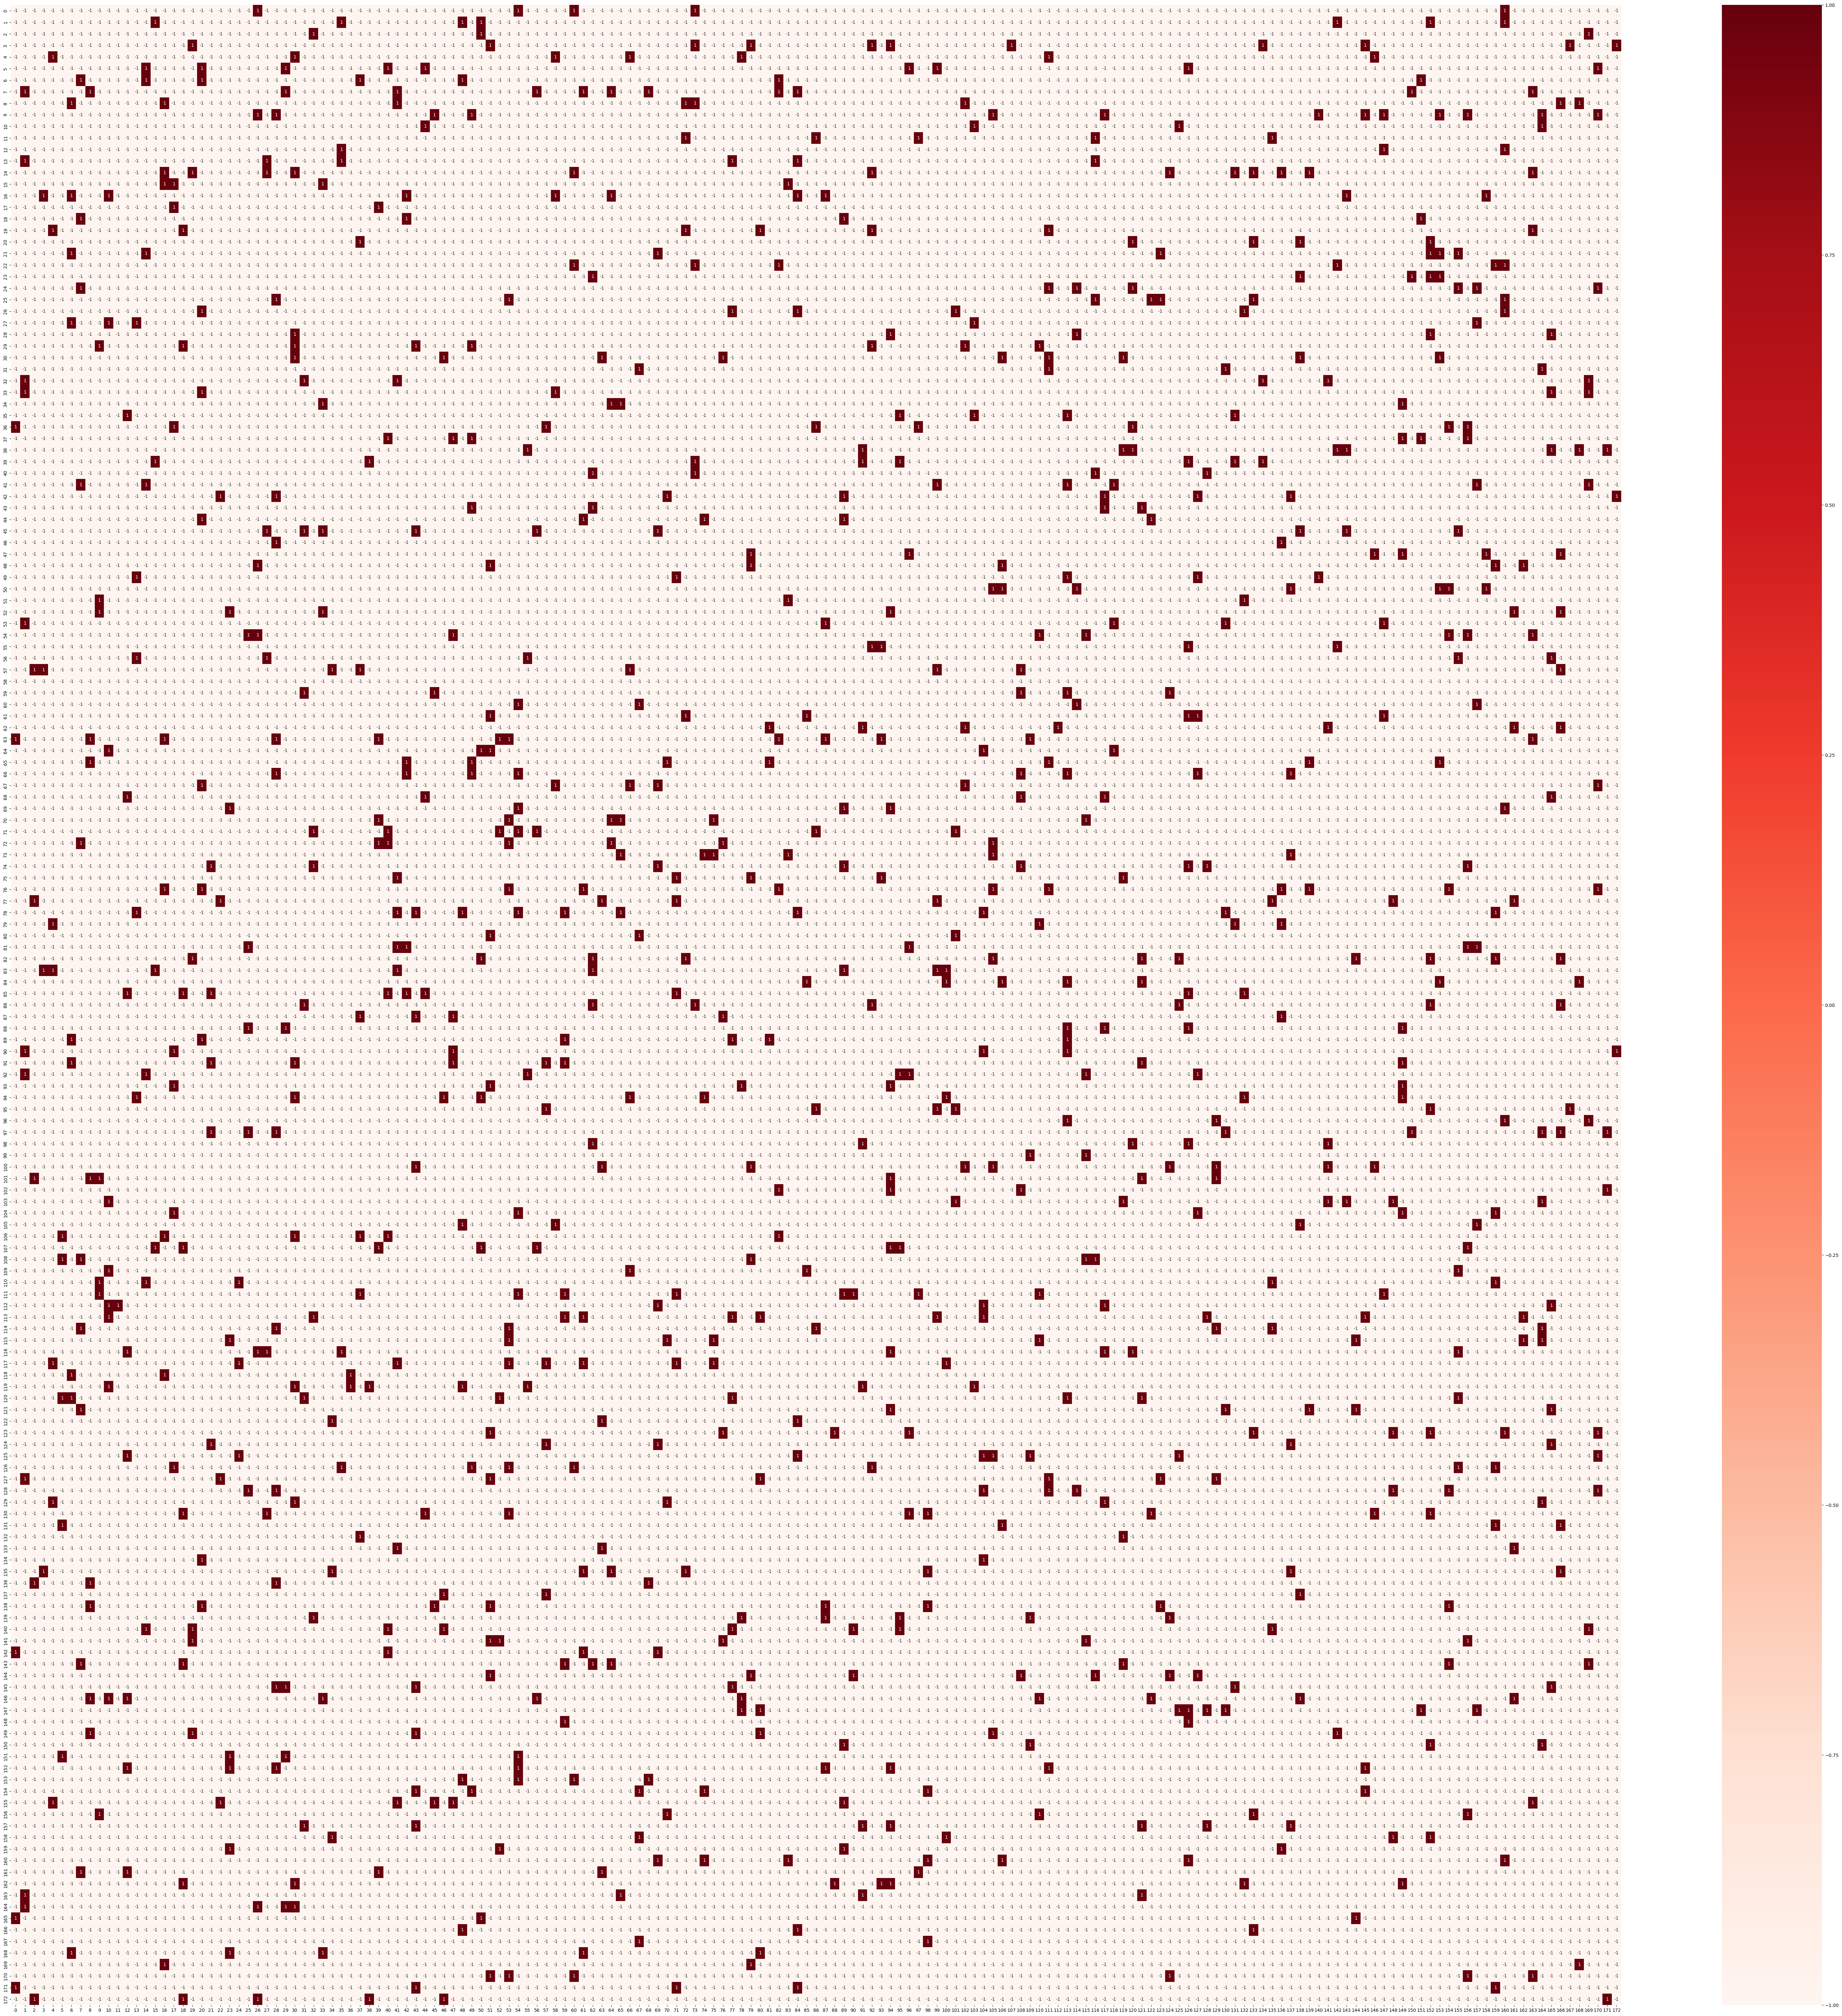

In [100]:
plt.figure(figsize=(80,80))  
sns.heatmap(w,  cmap="Reds", annot=True)

In [ ]:
for i in [10,100,1000,10000,100000,730000]:
    (trainingData, testData) = split(df.take(i),shuffle=True,ratio=0.7)
    clf = OneClassSVM(gamma='auto').fit(trainingData)
    a=clf.predict(testData)
    correctness=(len(a)-sum(a))*0.5/len(a)
    print("size:")
    print(i)
    print(correctness)

size:
10
1.0
size:
100
1.0
size:
1000
0.98


size:
10000
0.9753333333333334
